In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import math

!pip install cplex
import cplex
import matplotlib.pyplot as plt

### Buy and Hold Strategy

In [ ]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

### Equally Weighted Strategy

In [ ]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    # Calculate the portfolio value
    portfolio_value= np.dot(cur_prices, x_init) + cash_init
    #total number of stocks n=20
    num = 20
    # Weight Equal
    w = np.ones((20)) / num
    # equal weight for each stock
    value_each_stock = w * portfolio_value
    # Calculate shares for each stock
    x_optimal = np.floor(value_each_stock / cur_prices)
    # transcation fee
    cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
    # Find how much cash we left in the portfilio
    cash_optimal = portfolio_value- np.dot(cur_prices, x_optimal) - cost
    return x_optimal, cash_optimal

### Minimum Variance Strategy

In [ ]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # Calculate the portfolio value
    portfolio_value= np.dot(cur_prices,x_init) + cash_init
    # total number of stocks n=20
    num = 20
    # use cplex function
    cpx = cplex.Cplex()
    # minimize the variance
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * num
    lower_bound = [0.0] * num
    upper_bound = [1.0] * num
    lst = []
    for i in range(num):
        lst.append([[0,1],[1,0]])
    # set conditions for optimization problem
    cpx.linear_constraints.add(rhs = [1.0,0], senses = 'EG')
    variable_names = ['w_%s' % i for i in range(1, num + 1)]
    cpx.variables.add(obj = c, lb = lower_bound, ub = upper_bound, columns = lst, names = variable_names)
    # add quadratic part of objective function
    qmat = [[list(range(num)), list(2 * Q[k,:])] for k in range(num)]
    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters concurrent
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    # no results output
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Display minimum variance portfolio
    min_weight = np.array(cpx.solution.get_values())
    # wealth value for each stock with minimazing the variance
    value_each_stock = min_weight * portfolio_value
    # Calculate shares for each stock
    x_optimal = np.floor(value_each_stock / cur_prices)
    # transcation fee
    cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
    # Find how much cash in the portfilio
    cash_optimal = portfolio_value- np.dot(cur_prices, x_optimal) - cost
    return x_optimal, cash_optimal

### Maximum Sharpe Ratio Strategy

In [ ]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    # Calculate the portfolio value
    portfolio_value= cur_prices.dot(x_init) + cash_init
    # Set the number of stock equals to 21
    num = 21
    #risk-free rate for years 2020-2021 of 2.5%
    r_rf = 0.025
    # Calculate the daily risk-free rate 252 days per year
    daily_rf = 0.025 / 252
    # Add new column and new row for risk-free asset
    Q1 = np.append(Q,np.zeros((20,1)), axis = 1)
    Q2 = np.vstack([Q1,np.zeros((21))])
    # difference in mu_i and r_rf(CAPM)
    d = mu-daily_rf * np.ones(20)
    lst = []
    for i in range(num - 1):
        lst.append([[0,1],[d[i],1.0]])# diff.dot(y)==1
    lst.append([[0,1],[0,-1.0]])
    # use cplex function
    cpx = cplex.Cplex()
    # minimize the variance
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0] * num
    lower_bound = [0] * num
    upper_bound = [np.inf] * num
    var_names = ['y%s'% i for i in range(1, num + 1)]
    # Add objective function
    cpx.linear_constraints.add(rhs = [1.0,0],senses = 'EE')
    cpx.variables.add(obj = c, lb = lower_bound, ub = upper_bound, columns = lst, names = var_names)
    # add quadratic part of objective function
    qmat = [[list(range(num)),list(2*Q2[k,:])] for k in range(num)]
    cpx.objective.set_quadratic(qmat)
    # Set cplex parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    # no results output
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Show result
    result = np.array(cpx.solution.get_values())
    maxsharp_weight = result[0:20]/result[20]
    # wealth value for each stock BY minimazing the variance
    value_each_stock = maxsharp_weight * portfolio_value
    # generate corresponding shares for each stock
    x_optimal = np.floor(value_each_stock / cur_prices)
    # transaction fee
    cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
    cash_optimal = portfolio_value- np.dot(cur_prices,x_optimal) - cost
    return x_optimal, cash_optimal

In [ ]:
# Input file
input_file_prices = '/MIE1622A1/ts2020_2021.csv'

# Read data
df = pd.read_csv(input_file_prices)

# Convert to array [year month day]
def convert_date_to_array(datestr):
    temp= [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]





Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
 

In [ ]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]


In [ ]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      if cash[strategy, period-1] < 0:
          ###calculating the portfolio value
          port_value = np.dot(cur_prices,curr_positions) + curr_cash
          ratio = x[strategy, period-1]/sum(x[strategy, period-1])
          cash_neg = abs(cash[strategy, period-1])*ratio
          position_neg = np.ceil(cash_neg/cur_prices)
          x[strategy, period-1] = x[strategy, period-1] - position_neg
          tran_cost_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
          curr_val = np.dot(cur_prices,x[strategy, period-1])
          cash[strategy, period-1] = port_value - curr_val - tran_cost_new

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

In [ ]:
# Plot results
###################### Insert your code here ############################


Plot one chart in Python that illustrates the daily value of your portfolio (for each
trading strategy) over the years 2020 and 2021 using daily prices provided. Include the
chart in your report.

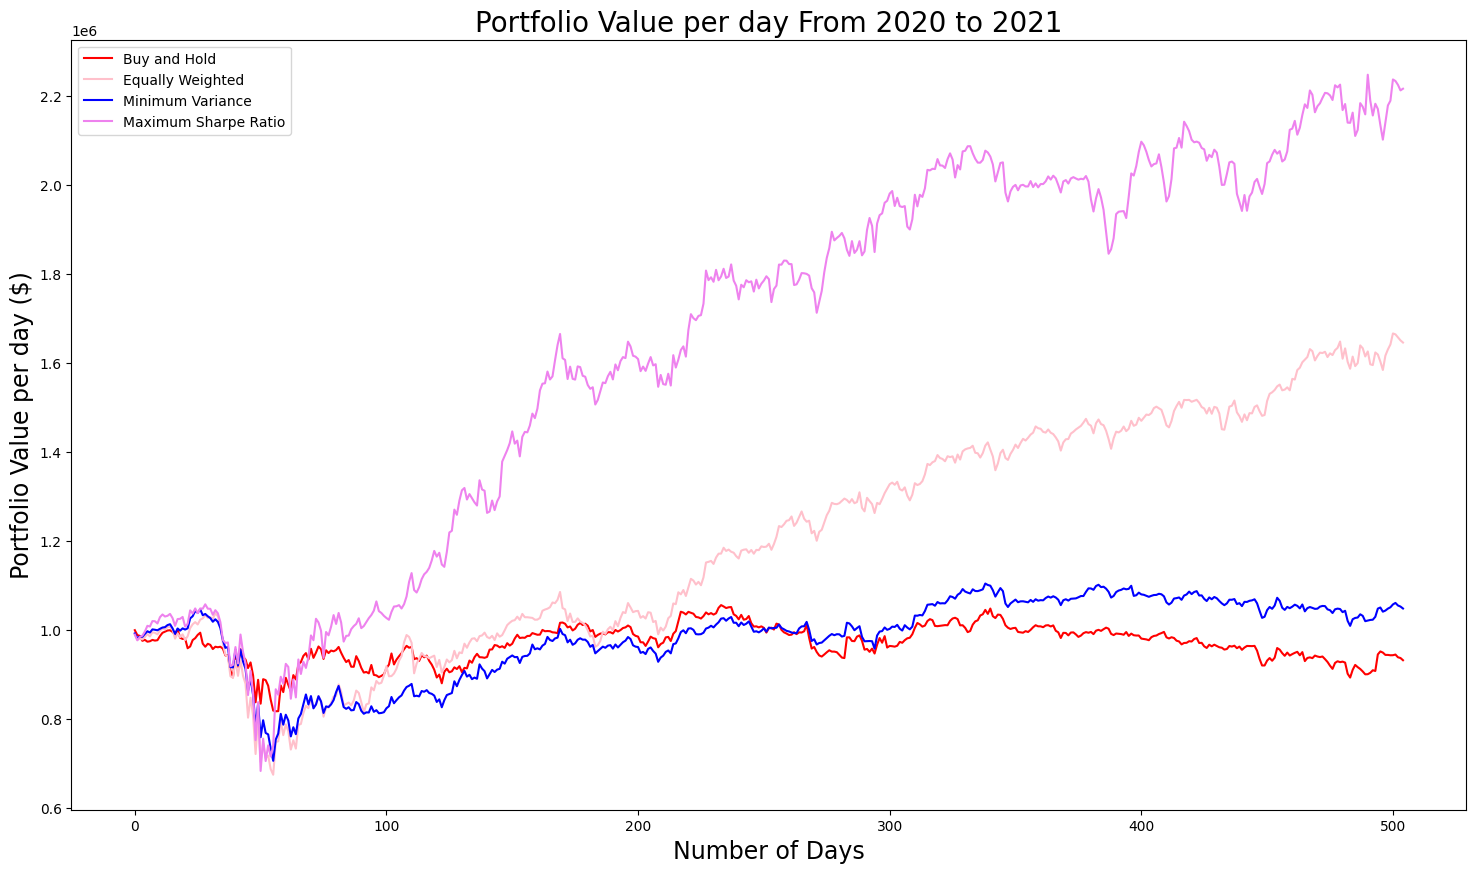

In [ ]:
plt.figure(figsize = (18, 10))
plt.plot(portf_value[0], label = 'Buy and Hold', color = 'red')
plt.plot(portf_value[1], label = 'Equally Weighted', color = 'pink')
plt.plot(portf_value[2], label = 'Minimum Variance', color = 'blue')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio', color = 'violet')
plt.title('Portfolio Value per day From 2020 to 2021', fontsize = 20)
plt.xlabel('Number of Days', fontsize = 17)
plt.ylabel('Portfolio Value per day ($)', fontsize = 17)
plt.legend()
plt.savefig('Portfolio Value per day From 2020 to 2021.png')
plt.show()

Plot two charts in Python for strategy 3 and 4 to show dynamic changes in portfolio
allocations. In each chart, x-axis represents the rolling up time horizon, y-axis denotes
portfolio weights between 0 and 1, and distinct lines display the position of selected assets
over time periods. You may use these figures to support your analysis or discussion.

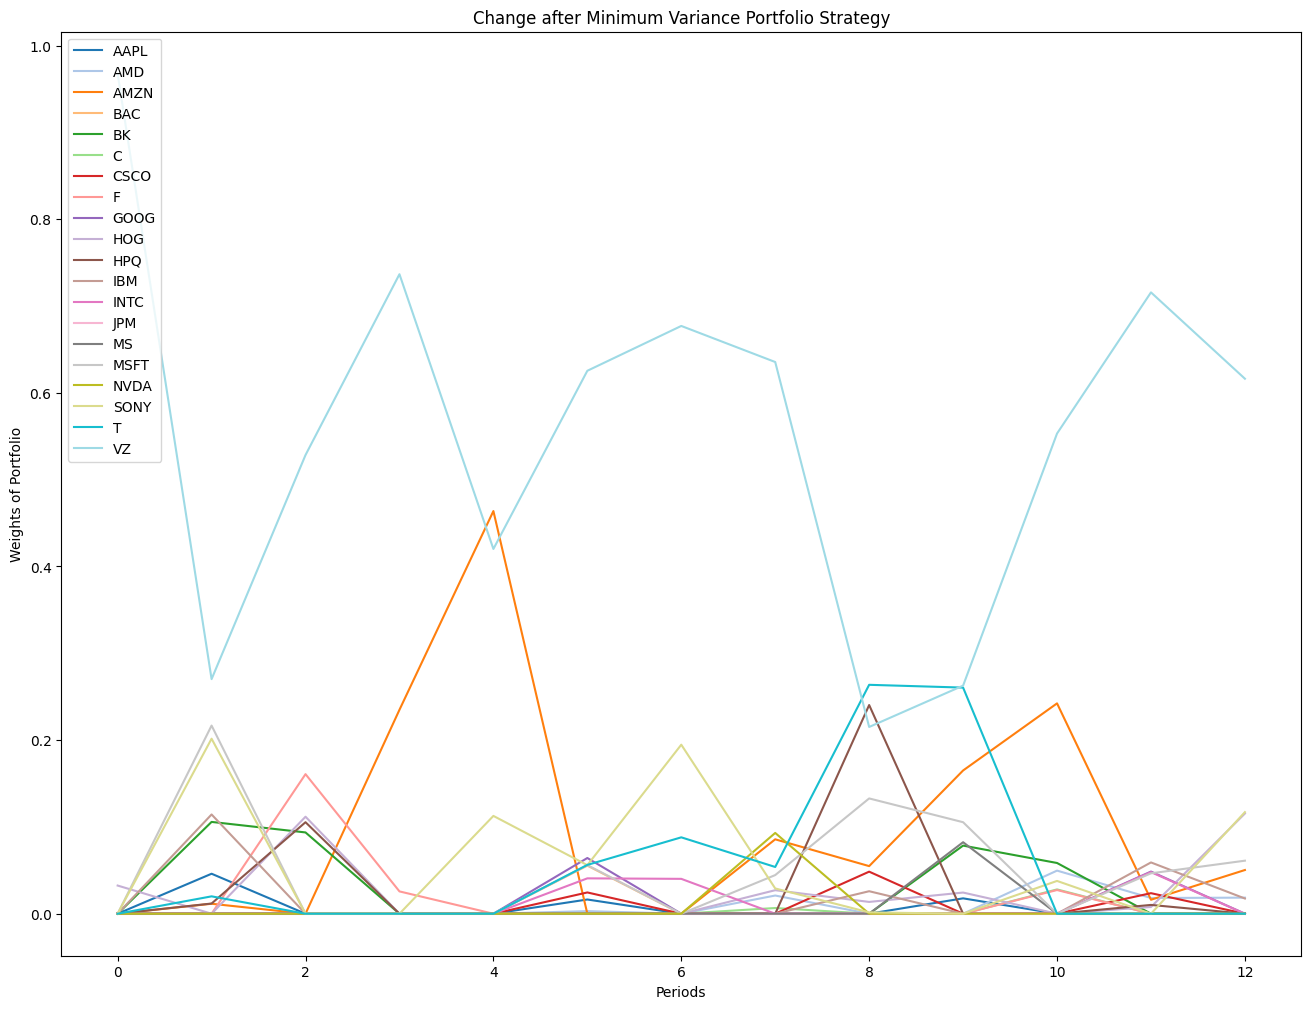

In [ ]:
assets = df.columns.values[1:]  # Excludes the first column which is likely dates


# 'init_value' is the total initial value of the portfolio
w_init = (data_prices[0, :] * init_positions) / init_value

# Initial weights and cash position
asset_weights = [w_init]  # Stores the initial weights of assets in the portfolio

for period in range(1, N_periods + 1):
    # Calculate the current year and month based on the period
    base_year = 20 if dates_array[0, 0] == 20 else 2020
    cur_year = base_year + math.floor(period / 7)
    cur_month = 2 * ((period - 1) % 6) + 1

    # Find indices for the start and end of the current month
    condition = (dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month)
    day_indices = np.where(condition)[0]
    if day_indices.size > 0:
        day_ind_start, day_ind_end = day_indices[0], day_indices[-1]
    else:
        continue  # Skip this period if no matching dates

    # Prices for the current period
    cur_prices = data_prices[day_ind_start, :]

    # Update the portfolio weights based on current prices
    total_value = np.dot(cur_prices, x[2, period - 1]) + cash[2, period - 1]
    new_weights = (cur_prices * x[2, period - 1]) / total_value
    asset_weights.append(new_weights)

# Create a DataFrame to store the asset weights over time
df_minvar = pd.DataFrame(asset_weights, columns=assets)

# Plotting
df_minvar.plot(figsize=(16, 12), cmap="tab20")
plt.title('Change after Minimum Variance Portfolio Strategy')
plt.xlabel('Periods')
plt.ylabel('Weights of Portfolio')
plt.legend(loc='upper left')
plt.savefig('Dynamic Change Minimum Variance.png')
plt.show()

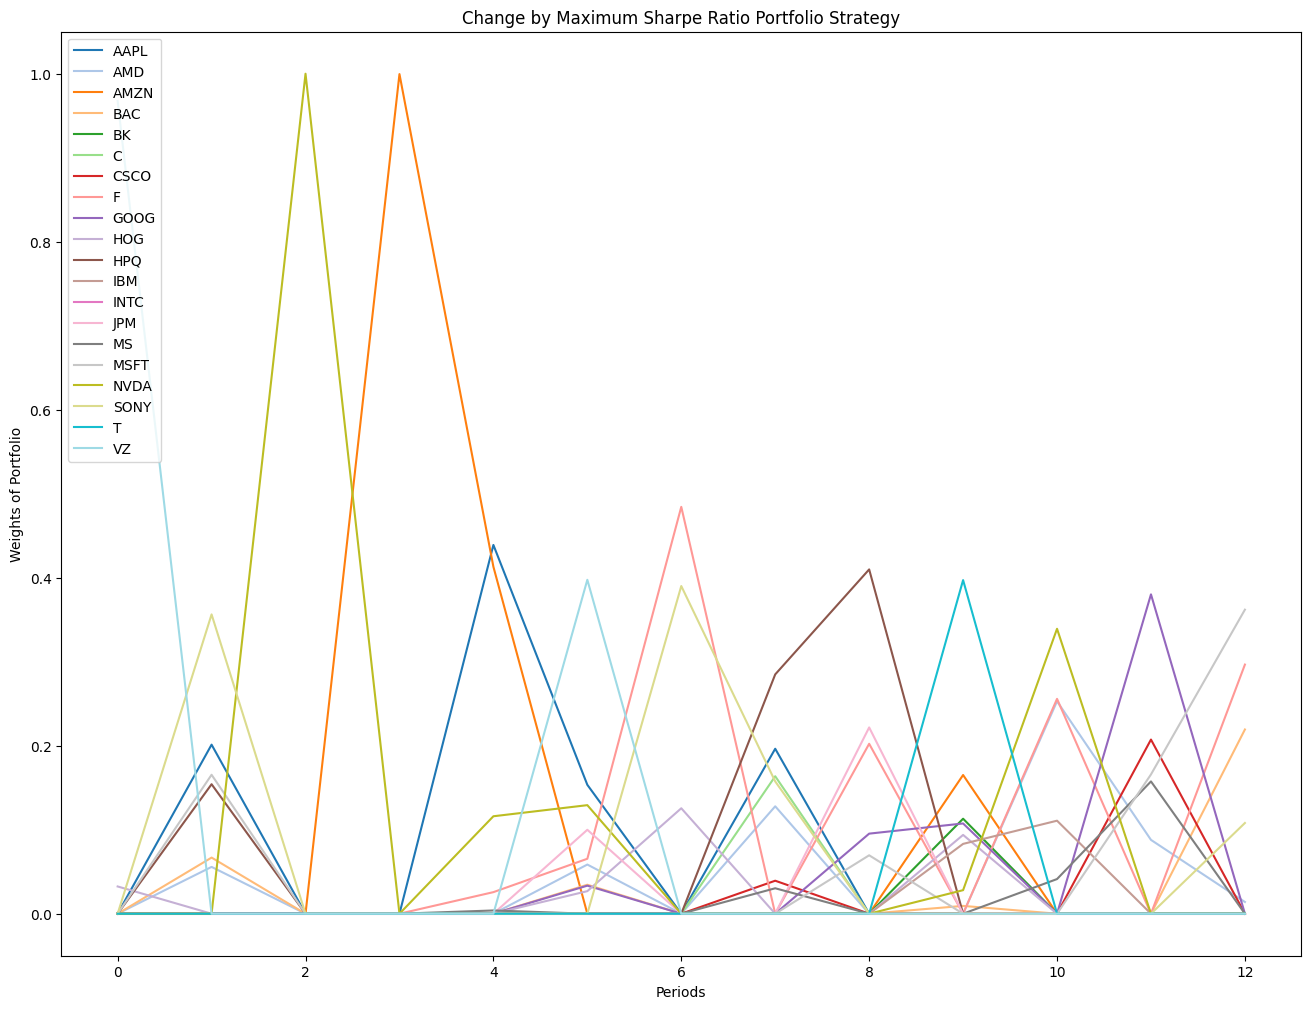

In [ ]:
# Initialize with the starting weights for the assets in the portfolio
asset_weights_max_sharpe = [w_init]

for period in range(1, N_periods + 1):
    # Determine the current year and month for the trading period
    base_year = 20 if dates_array[0, 0] == 20 else 2020
    cur_year = base_year + math.floor(period / 7)
    cur_month = 2 * ((period - 1) % 6) + 1

    # Identify start and end day index for the current month
    condition = (dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month)
    day_indices = np.where(condition)[0]
    if day_indices.size > 0:
        day_ind_start, day_ind_end = day_indices[0], day_indices[-1]
    else:
        continue  # Skip this period if no matching dates

    # Current prices for the period
    cur_prices = data_prices[day_ind_start, :]

    # Update portfolio weights based on the current prices and asset positions
    total_value = np.dot(cur_prices, x[3, period - 1]) + cash[3, period - 1]
    new_weights = (cur_prices * x[3, period - 1]) / total_value
    asset_weights_max_sharpe.append(new_weights)

# Create a DataFrame to hold the portfolio weights over each period
df_maxsharpe = pd.DataFrame(asset_weights_max_sharpe, columns=assets, index=np.arange(0, N_periods + 1))

# Plotting the evolution of portfolio weights over time
df_maxsharpe.plot(figsize=(16, 12), cmap="tab20")
plt.title('Change by Maximum Sharpe Ratio Portfolio Strategy')
plt.xlabel('Periods')
plt.ylabel('Weights of Portfolio')
plt.legend(loc='upper left')
plt.savefig('Dynamic Change Maximum Sharpe.png')
plt.show()

Compare your trading strategies and discuss their performance relative to each other.
Which strategy would you select for managing your own portfolio and why?

It appears that the Maximum Sharpe Ratio approach causes some assets to be given more extreme weights at different times. This suggests a more aggressive approach that alters the allocation in a big way to optimize return on risk. The Maximum Sharpe approach exhibits more noticeable spikes, whereas the Minimum Variance strategy seems to have a slightly smoother transition between periods. This implies that over time, the Minimum Variance method is more stable. Over time, the Minimum Variance method appears to sustain a more diversified portfolio across various assets. On the other hand, the Maximum Sharpe Ratio approach sometimes heavily weights a small number of assets, decreasing diversity during those periods and perhaps signaling increased risk in the event that those specific assets underperform. The Maximum Sharpe Ratio approach may result in greater transaction costs, which could have an impact on net returns, if there is a correlation between increased weight variability and higher portfolio turnover. The Minimum Variance strategy may offer superior protection against downside risk in a down market or a market with significant levels of uncertainty, but the aggressive stance of the Maximum Sharpe Ratio may be more advantageous in these situations.

test your Python program for different variations of your strategies, e.g., select “1/n”
portfolio at the beginning of period 1 and hold it till the end of period 12 (as if the re-
balancing strategy required large transaction costs).

In [ ]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])
x_equal_hold, cash_equal_hold = strat_equally_weighted(init_positions, 0, mu, Q, data_prices[0])

print('Amount of Asset in each stock with Equal Weight and Hold Strategy:\n', x_equal_hold)

Amount of Asset in each stock with Equal Weight and Hold Strategy:
 [ 675. 1018.   26. 1468. 1041.  659. 1097. 5425.   36. 1389. 2560.  426.
  864.  378. 1013.  317.  835.  724. 1507.  904.]


In [ ]:
def strat_buy_and_hold_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    x_init = np.array(x_init)
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    x_optimal = np.array([ 675., 1018.,   26., 1468., 1041.,  659., 1097., 5425.,   36.,
       1389., 2560.,  426.,  864.,  378., 1013.,  317.,  835.,  724.,
       1507.,  904.])
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost
    return x_optimal, cash_optimal

Output

In [ ]:
# Input file
input_file_prices = '/MIE1622A1/ts2020_2021.csv'

# Read data
df = pd.read_csv(input_file_prices)

# Convert to array [year month day]
def convert_date_to_array(datestr):
    temp= [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [ ]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe','strat_buy_and_hold_equally_weighted']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio','buy and hold equally weighted Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_buy_and_hold_equally_weighted]


Initial portfolio value = $ 1000012.93



In [ ]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      if cash[strategy, period-1] < 0:
          ###calculating the portfolio value
          port_value = np.dot(cur_prices,curr_positions) + curr_cash
          ratio = x[strategy, period-1]/sum(x[strategy, period-1])
          cash_neg = abs(cash[strategy, period-1])*ratio
          position_neg = np.ceil(cash_neg/cur_prices)
          x[strategy, period-1] = x[strategy, period-1] - position_neg
          tran_cost_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
          curr_val = np.dot(cur_prices,x[strategy, period-1])
          cash[strategy, period-1] = port_value - curr_val - tran_cost_new

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60
  Strategy "buy and hold equally weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47
  Strategy "buy and hold equally weighted Portfolio", value begin = $

Plot and compare

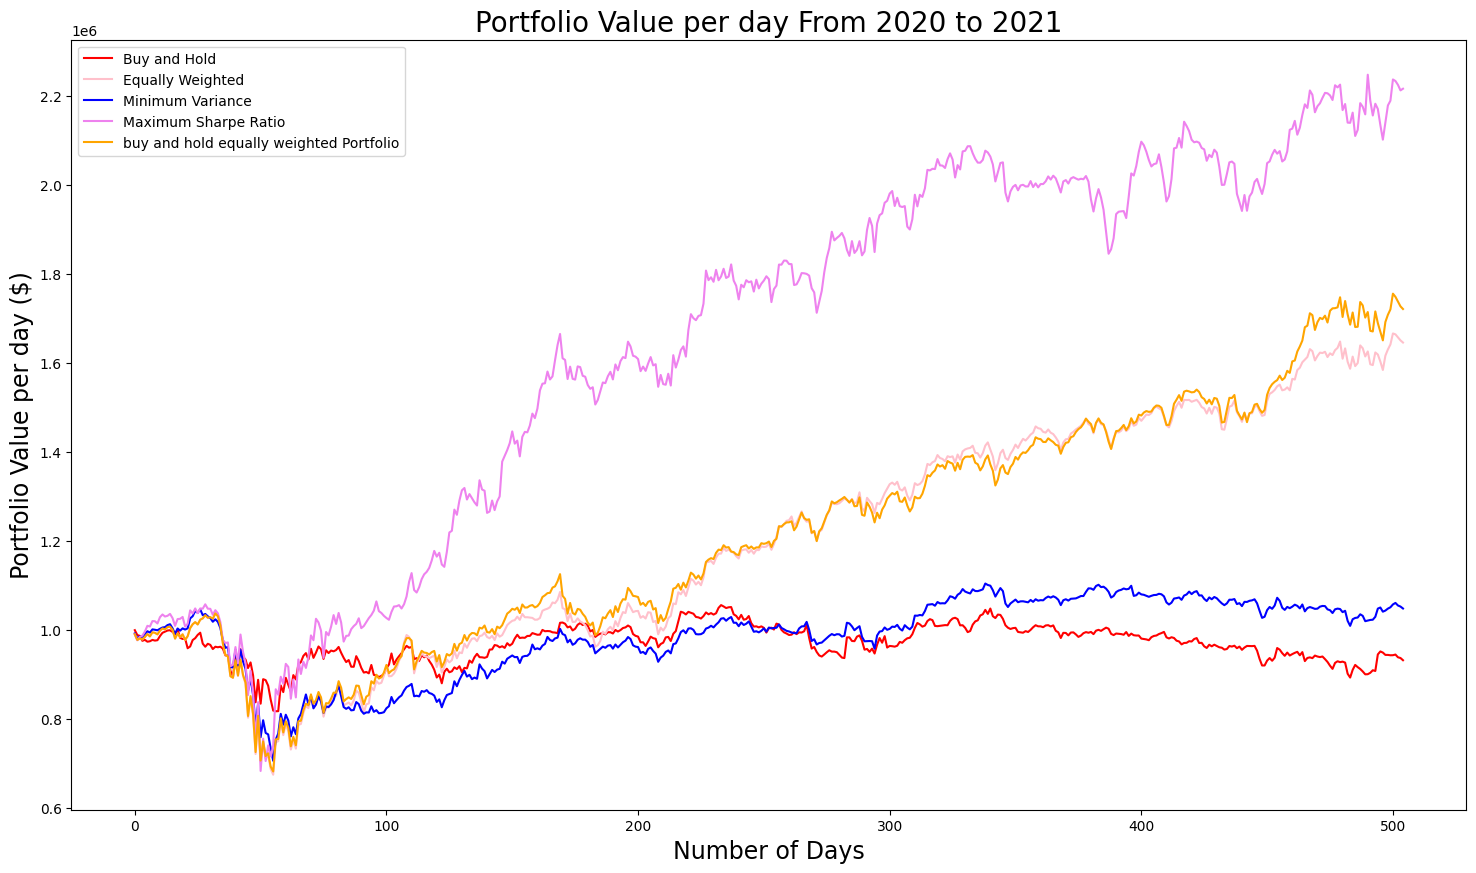

In [ ]:
plt.figure(figsize = (18, 10))
plt.plot(portf_value[0], label = 'Buy and Hold', color = 'red')
plt.plot(portf_value[1], label = 'Equally Weighted', color = 'pink')
plt.plot(portf_value[2], label = 'Minimum Variance', color = 'blue')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio', color = 'violet')
plt.plot(portf_value[4], label = 'buy and hold equally weighted Portfolio', color = 'orange')
plt.title('Portfolio Value per day From 2020 to 2021', fontsize = 20)
plt.xlabel('Number of Days', fontsize = 17)
plt.ylabel('Portfolio Value per day ($)', fontsize = 17)
plt.legend()
plt.savefig('Portfolio Value per day From 2020 to 2021.png')
plt.show()

Comment on the new strategy, this approach performs better in the end than the typical buy and hold strategy, indicating that equal weighting in a buy and hold setting may produce superior outcomes than a non-weighted buy and hold strategy. The Buy and Hold Equally Weighted Portfolio continues to perform better than the active strategies (Minimum Variance and Maximum Sharpe Ratio), notwithstanding the improvement. In conclusion, the second plot's inclusion of the Buy and Hold Equally Weighted Portfolio demonstrates that it can be superior to the straightforward Buy and Hold approach. Still, carefully controlled strategies—that is, the Maximum Sharpe Ratio in particular—produce superior outcomes.This may imply that while simple rules such as equal weighting can improve passive strategies, active portfolio management based on risk-return optimization measurements (such as Sharpe Ratio) may be able to provide superior performance in terms of portfolio value increase over an extended period of time.


Can you suggest any improvements of the trading strategies that you have implemented?

Consider Management of Transaction fees: Buying and selling frequently is a feature of active methods, which can lead to high transaction costs. Should these expenses be substantial, they may counteract the benefits of proactive management. Think about putting in place a rebalancing threshold, whereby the portfolio is only adjusted when the weights stray from the goal by a specific percentage.

Consider Risk-Adjusted Returns: Although the Maximum Sharpe Ratio approach yields the highest final value, it is important to take into account the risk incurred in order to attain these returns. A more impartial assessment of performance might be obtained by including additional risk-adjusted performance measures, such as the Sortino Ratio, which concentrates on downside volatility.

Leverage and Shorting: Examine how leverage can be used to boost returns in risk-adjusted strategies that regularly outperform. Likewise, think about using shorting as a tactic to protect long positions or profit from falling asset prices.